In [1]:
import pandas as pd
import geopandas as gp
import numpy as np 
import xlrd
import os
import fiona
from statistics import mean, median
import string
import math
import re

from shapely.geometry import Polygon
from shapely.ops import cascaded_union

pd.set_option('display.max_rows', 200)

# VEST IA 2020

## VEST Documentation

### Sources

Election results from Iowa Secretary of State (https://sos.iowa.gov/elections/results/index.html)<br>
Precinct shapefile primarily from IA Secretary of State (https://sos.iowa.gov/shapefiles/)

### Shapefiles

The following counties instead use shapefiles sourced from the respective county governments: Dallas, Dubuque, Johnson, Linn, Polk, Pottawattamie, Scott, Story. The following counties were aligned with updated municipal boundaries from the U.S. Census Bureau's 2020 Redistricting Data Program: Marion, Muscatine, Woodbury. Mitchell County was edited to match the revised 2020 precinct map from the county.

The following precincts were merged to match the 2020 general election results.

Appanoose: Udell/Union<br>
Black Hawk: Cedar Falls W2P2/Cedar Falls Twp<br>
Cass: Atlantic 1/BR-GV-WS-PY, Atlantic 2/3, 4/5, BN-FR/GN-LN<br>
Davis: Bloomfield 1/2/3<br>
Des Moines: Burlington 1/Tama, Burlington 8/Concordia<br>
Fremont: Hamburg/Washington, Farragut/Shenandoah1<br>
Henry: Mt Pleasant 1/2/3/4<br>
Howard: Cresco 1/2/3<br>
Lee: Fort Madison 4A/4B, Keokuk 2A/2B, FCM/Harrison<br>
Mitchell: Precinct 1/12, 3/10/11, 5/6, 7/8/9<br>
Polk: Grimes 2/Urbandale 12<br>
Tama: Toledo 1/2/3<br>

### Races

G20PRERTRU - Donald J. Trump (Republican Party)<br>
G20PREDBID - Joseph R. Biden (Democratic Party)<br>
G20PRELJOR - Jo Jorgensen (Libertarian Party)<br>
G20PREGHAW - Howie Hawkins (Green Party)<br>
G20PRECBLA - Don Blakenship (Constitution Party)<br>
G20PREOFUE - Roque Rocky De La Fuente (Alliance Party)<br>
G20PREOKIN - Ricki Sue King (Genealogy Know Your Family History Party)<br>
G20PREIWES - Kanye West (Independent)<br>
G20PREIPIE - Brock Pierce (Independent)<br>
G20PREOWRI - Write-in Votes<br>
<br>
G20USSRERN - Joni Ernst (Republican Party)<br>
G20USSDGRE - Theresa Greenfield (Democratic Party)<br>
G20USSLSTE - Rick Stewart (Libertarian Party)<br>
G20USSOHER - Suzanne Herzog (Independent)<br>
G20USSOWRI - Write-in Votes<br>

## Load in VEST file

In [2]:
vest_ia_2020 = gp.read_file("./raw-from-source/VEST/ia_2020/ia_2020.shp")

<AxesSubplot:>

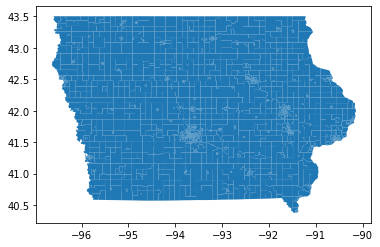

In [3]:
vest_ia_2020.plot()

In [4]:
vest_ia_2020.columns

Index(['COUNTY', 'DISTRICT', 'NAME', 'G20PRERTRU', 'G20PREDBID', 'G20PRELJOR',
       'G20PREGHAW', 'G20PRECBLA', 'G20PREOFUE', 'G20PREOKIN', 'G20PREIWES',
       'G20PREIPIE', 'G20PREOWRI', 'G20USSRERN', 'G20USSDGRE', 'G20USSLSTE',
       'G20USSOHER', 'G20USSOWRI', 'geometry'],
      dtype='object')

## Build table of precinct-level election results from IA SOS Spreadsheets

Notes:
- Scott.xlsx does not open -- maybe try downloading it again?
    - it's a PDF... needs to be digitized.
- Each candidate has three columns of votes for each precinct: 
    - Election Day votes
    - Absentee votes
    - Total votes

In [5]:
ER_INPUT_DIR = './raw-from-source/Election_Results/'
input_files = os.listdir(ER_INPUT_DIR)

In [6]:
# outputs the number of columns in each county's presidential results page. 

col_counts = []

RUN_CHECK = False

if RUN_CHECK:
    ER_INPUT_DIR = './raw-from-source/Election_Results/'
    input_files = os.listdir(ER_INPUT_DIR)
    # temp files associated with open excel spreadsheets start with "~$"
    for fn in list(filter(lambda e: e.endswith('.xlsx') and not e.startswith('~$'), input_files)):
        county_name = fn.strip('.xlsx')
        xls_sheets = pd.read_excel(os.path.join(ER_INPUT_DIR, fn), sheet_name=['2', '3'], skiprows=1)
        pres_xls = xls_sheets['2']
        column_count = len(list(pres_xls.loc[0]))
        col_counts.append({'County': county_name, 'Columns': column_count})
        
    col_counts_df = pd.DataFrame.from_records(col_counts)
    col_counts_df.to_csv('./pres_col_counts.csv', index=False)

In [7]:
pres_labels_to_vest = {
    'Donald J. Trump and Michael R. Pence': 'G20PRERTRU',
    'Joseph R. Biden and Kamala D. Harris': 'G20PREDBID',
    'Jo Jorgensen and Jeremy Cohen': 'G20PRELJOR',
    'Howie Hawkins and Angela Nicole Walker': 'G20PREGHAW',
    'Don Blankenship and William Alan Mohr': 'G20PRECBLA',
    'Roque Rocky De La Fuente and Darcy G. Richardson': 'G20PREOFUE',
    'Ricki Sue King and Dayna R. Chandler': 'G20PREOKIN',
    'Kanye West and Michelle Tidball': 'G20PREIWES',
    'Brock Pierce and Karla Ballard': 'G20PREIPIE',
    'Write-in': 'G20PREOWRI'
}

sen_labels_to_vest = {
    'Joni Ernst': 'G20USSRERN',
    'Theresa Greenfield': 'G20USSDGRE',
    'Rick Stewart': 'G20USSLSTE',
    'Suzanne Herzog': 'G20USSOHER',
    'Write-in': 'G20USSOWRI'
}

Builds a cleaned dataframe of precinct results for a given county from its SOS spreadsheet. Works for both raw presidential and senate sheets.

In [8]:
def build_results_dataframe(county_pres_xls, county_name):
    column_count = len(list(county_pres_xls.loc[0]))
    
    # Label the precinct row, and drop the registered voters and total votes columns. 
    #
    # The 1st (zero-indexed) and right-most column contain registered voters and total information respectively,
    # Registered voters column is unreliable, and total can be re-calculated, so throw them both out now. 
    county_pres_xls.at[0, 'Unnamed: 0'] = 'Precinct'
    rhs_col_label = 'Unnamed: {0}'.format(column_count-1)
    county_pres_xls = county_pres_xls.drop(columns = ['Unnamed: 1', rhs_col_label])

    # extract the list of candidates in this table by filtering out the "Unnamed: N" values in the column labels.
    column_labels = list(county_pres_xls.columns)
    candidates = [e for e in column_labels if not e.startswith('Unnamed:')]

    # expand the names of the candidates to span each of the three "vote type" columns which contain their results
    new_candidate_row = ['Precinct']
    for candidate_name in candidates:
        new_candidate_row += [candidate_name, candidate_name, candidate_name]
    county_pres_xls.columns = new_candidate_row

    # separate the precinct results from the vote-type columns so we can re-apply this information correctly as a multi-index. 
    results_df = county_pres_xls.loc[1:len(pres_xls)-2].copy(deep=True)
    
    # add a county row
    results_df['County'] = county_name

    # Clean the precinct column and make the county & precinct this table's index
    results_df['Precinct'] = results_df['Precinct'].apply(lambda e: e.strip())
    results_df = results_df.set_index(['County', 'Precinct'])
    
    # Create a MultiIndexed column header so we can include candidate names and vote types all in one row. 
    results_df.columns = pd.MultiIndex.from_product([candidates, ['Election Day', 'Absentee', 'Total Votes']])

    # We can move the "vote type" dimension of this data to its own column with .stack()
    results_df = results_df.stack()
    results_df.index = results_df.index.rename(['County', 'Precinct', 'Vote Type'])

    # Drop the "total votes" vote type. 
    results_df = results_df.drop('Total Votes', level=2, axis=0)

    # apply a consistent ordering of the candidate columns
    results_df = results_df[list(candidates)]    
    return results_df

Extract the presidential and senate data from each county's spreadsheets, merge it all into one file, and write it to disk.

In [9]:
county_results = {}

SHOULD_PROCESS_INPUT_DATA = False

if SHOULD_PROCESS_INPUT_DATA:
    input_files = os.listdir(ER_INPUT_DIR)
    # temp files associated with open excel spreadsheets start with "~$"
    for fn in list(filter(lambda e: e.endswith('.xlsx') and not e.startswith('~$'), input_files)):
        county_name = fn.split('.xlsx')[0]
        xls_sheets = pd.read_excel(os.path.join(ER_INPUT_DIR, fn), sheet_name=['2', '3'], skiprows=1)
        
        # Presidential results are in tables on separate sheets (pres = '2', senate = '3'). 
        pres_xls = xls_sheets['2']
        senate_xls = xls_sheets['3']
        
        # Build cleaned dataframes from the raw results
        pres_df = build_results_dataframe(pres_xls, county_name)
        senate_df = build_results_dataframe(senate_xls, county_name)
        
        # standardize senate and presidential candidate names by replacing w/ their vest IDs
        pres_df.columns = list(map(lambda e: pres_labels_to_vest[e], list(pres_df.columns)))
        senate_df.columns = list(map(lambda e: sen_labels_to_vest[e], list(senate_df.columns)))

        # join the presidential and senate results, using the presidential frame as a base.
        county_res_df = pres_df.merge(senate_df, how='outer', left_on=['County', 'Precinct', 'Vote Type'], right_on=['County', 'Precinct', 'Vote Type'])
        county_results[county_name] = county_res_df
        
    # add in Scott county's digitized precinct results
    scott_pres_df = pd.read_csv(os.path.join(ER_INPUT_DIR, 'scott-pres-digitized.csv'))
    scott_pres_df = scott_pres_df.set_index(['County', 'Precinct', 'Vote Type'])
    scott_sen_df = pd.read_csv(os.path.join(ER_INPUT_DIR, 'scott-sen-digitized.csv'))
    scott_sen_df = scott_sen_df.set_index(['County', 'Precinct', 'Vote Type'])
    scott_combined_df = scott_pres_df.merge(scott_sen_df, how='outer', left_on=['County', 'Precinct', 'Vote Type'], right_on=['County', 'Precinct', 'Vote Type'])
    # Drop each county's "total" vote type row in Scott's results
    scott_combined_df = scott_combined_df.drop('Total', level=2, axis=0)
    county_results['Scott'] = scott_combined_df
    
    # combine each county's results together to create a single statewide precinct results datafile 
    all_results_df = pd.concat(list(county_results.values()), axis=0)
    all_results_df = all_results_df.reset_index()
    all_results_df = all_results_df.sort_values(['County', 'Precinct'])
    all_results_df.to_csv('./ia-2020-statewide-precinct-results.csv')

## Load in Raw Election Results
NOTE: This is just the file we created in the "Build table of precinct-level election results from IA SOS Spreadsheets" section above.

In [10]:
results_df = pd.read_csv('./ia-2020-statewide-precinct-results.csv')

Group absentee and election day votes together so we can check statewide/countywide results.

In [11]:
er_2020_df = pd.read_csv('./ia-2020-statewide-precinct-results.csv')
er_2020_df = er_2020_df.sort_values(['County', 'Precinct'])
er_2020_df = er_2020_df.groupby(['County', 'Precinct']).sum()

In [12]:
er_2020_df = er_2020_df.reset_index()

## Validate statewide totals

In [13]:
races = list(pres_labels_to_vest.values()) + list(sen_labels_to_vest.values())

In [14]:
def statewide_totals_check(partner_df,source_df,column_list):
    print("***Statewide Totals Check***")
    for race in column_list:
        if (partner_df[race].sum()- source_df[race].sum() != 0):
            print(race+" has a difference of "+str(partner_df[race].sum()-source_df[race].sum())+" votes")
            print("\tVEST: "+str(partner_df[race].sum())+" votes")
            print("\tSOURCES: "+str(source_df[race].sum())+" votes")
        else:
            print(race + " is equal", "\tVEST / RDH: " + str(partner_df[race].sum()))

In [15]:
statewide_totals_check(vest_ia_2020, er_2020_df, races)

***Statewide Totals Check***
G20PRERTRU is equal 	VEST / RDH: 897672
G20PREDBID is equal 	VEST / RDH: 759061
G20PRELJOR is equal 	VEST / RDH: 19637
G20PREGHAW is equal 	VEST / RDH: 3075
G20PRECBLA is equal 	VEST / RDH: 1707
G20PREOFUE is equal 	VEST / RDH: 1082
G20PREOKIN is equal 	VEST / RDH: 546
G20PREIWES is equal 	VEST / RDH: 3210
G20PREIPIE is equal 	VEST / RDH: 544
G20PREOWRI is equal 	VEST / RDH: 4337
G20USSRERN is equal 	VEST / RDH: 864997
G20USSDGRE is equal 	VEST / RDH: 754859
G20USSLSTE is equal 	VEST / RDH: 36961
G20USSOHER is equal 	VEST / RDH: 13800
G20USSOWRI is equal 	VEST / RDH: 1211


## Validate county totals

Change O'Brien county's name to correspond to its entry in the FIPS dictionary.

In [16]:
er_2020_df.replace({"O'Brien": "Obrien"}, inplace=True)

Convert 'County' column in our results to a FIPS column.

In [17]:
fips_df = pd.read_csv('./raw-from-source/FIPS/US_FIPS_CODES.csv')
ne_fips_df = fips_df.loc[fips_df['FIPS State'] == 19]
fl = ne_fips_df[['FIPS County', 'County Name']].to_dict('list')
fips_dict = dict(zip(fl['County Name'], fl['FIPS County']))
er_2020_df['FIPS'] = er_2020_df['County'].apply(lambda e: str(fips_dict[e]).zfill(3)).copy()
er_2020_df = er_2020_df[(['FIPS', 'Precinct'] + races)]
er_2020_df = er_2020_df.rename(columns={'FIPS':'COUNTY', 'Precinct': 'NAME'})
ia_2020_df = er_2020_df[(['COUNTY', 'NAME'] + races)]

VEST's data doesn't have a FIPS column, so I'm going to create one and move the human-readable county names to a column called `COUNTY_NAME` 

In [18]:
vest_ia_2020['COUNTY_NAME'] = vest_ia_2020['COUNTY'] 
vest_ia_2020['COUNTY'] = vest_ia_2020['COUNTY'].apply(lambda e: str(fips_dict[e]).zfill(3)).copy()

In [19]:
def county_totals_check(partner_df,source_df,column_list,county_col,full_print=False):
    print("***Countywide Totals Check***")
    print("")
    diff_counties=[]
    for race in column_list:
        diff = partner_df.groupby([county_col]).sum()[race]-source_df.groupby([county_col]).sum()[race]
        for val in diff[diff != 0].index.values.tolist():
            if val not in diff_counties:
                diff_counties.append(val)
        if len(diff[diff != 0]!=0):   
            print(race + " contains differences in these counties:")
            for val in diff[diff != 0].index.values.tolist():
                county_differences = diff[diff != 0]
                print("\t"+val+" has a difference of "+str(county_differences[val])+" votes")
                print("\t\tVEST: "+str(partner_df.groupby([county_col]).sum().loc[val,race])+" votes")
                print("\t\tSOURCES: "+str(source_df.groupby([county_col]).sum().loc[val,race])+" votes")
            if (full_print):
                for val in diff[diff == 0].index.values.tolist():
                    county_similarities = diff[diff == 0]
                    print("\t"+val + ": "+ str(partner_df.groupby([county_col]).sum().loc[val,race])+" votes")
        else:
            print(race + " is equal across all counties")
            if (full_print):
                for val in diff[diff == 0].index.values.tolist():
                    county_similarities = diff[diff == 0]
                    print("\t"+val + ": "+ str(partner_df.groupby([county_col]).sum().loc[val,race])+" votes")

In [20]:
county_totals_check(vest_ia_2020, ia_2020_df, races, 'COUNTY', full_print=False)

***Countywide Totals Check***

G20PRERTRU is equal across all counties
G20PREDBID is equal across all counties
G20PRELJOR is equal across all counties
G20PREGHAW is equal across all counties
G20PRECBLA is equal across all counties
G20PREOFUE is equal across all counties
G20PREOKIN is equal across all counties
G20PREIWES is equal across all counties
G20PREIPIE is equal across all counties
G20PREOWRI is equal across all counties
G20USSRERN is equal across all counties
G20USSDGRE is equal across all counties
G20USSLSTE is equal across all counties
G20USSOHER is equal across all counties
G20USSOWRI is equal across all counties


## Merge Source results onto VEST

In [21]:
vest_ia_2020['unique_ID'] = vest_ia_2020['COUNTY'] + '-' + vest_ia_2020['NAME']
ia_2020_df['unique_ID'] = ia_2020_df['COUNTY'] + '-' + ia_2020_df['NAME']

Perform the first merge

In [22]:
merge_1_df = pd.merge(vest_ia_2020, ia_2020_df, how='outer', on='unique_ID', indicator=True, validate='1:1').copy(deep=True)

# Compare the number of rows with NaN values (failed joins) against the number without any (successful joins). 
nan_rows = merge_1_df[merge_1_df.isnull().any(axis=1)]
valid_rows = merge_1_df[~merge_1_df.isnull().any(axis=1)]
print(merge_1_df['_merge'].value_counts())

left_only     1100
right_only    1100
both           561
Name: _merge, dtype: int64


In [23]:
merge_1_df.loc[merge_1_df['_merge'] == 'right_only'].to_csv('./source-only.csv', index=False)
merge_1_df.loc[merge_1_df['_merge'] == 'left_only'].to_csv('./vest-only.csv', index=False)
merge_1_df.loc[merge_1_df['_merge'] == 'both'].to_csv('./both.csv', index=False)

Apply the source precinct -> VEST precinct ID mapping and perform the final merge.

In [24]:
nan = np.nan
s2v = {'001-1 NW': '001-1NW Adair', '001-2 NE': '001-2NE Stuart', '001-3 SW': '001-3SW Fontanelle', '001-4 SE': '001-4SE Orient', '001-5 GF': '001-5GF Greenfield', '005-Pct - PO/FK': '005-Pct 03 - PO/FK', '005-Pct 1-WL/HV': '005-Pct 01 - WL/HV', '005-Pct 11 Waukon 3': '005-Pct 11 - Waukon 3', '005-Pct 2-FC/JF/LL/MK/UP': '005-Pct 02 - FC/JF/LL/MK/UP', '005-Pct 4 - Postville City': '005-Pct 04 - PV City', '005-Pct 5 - LT/PC/WV CITY': '005-Pct 05 - LT/PC/WV City', '005-Pct 6 - FV/TL/HF CITY': '005-Pct 06 - FV/TL/HF City', '005-Pct 7 - CN/LF/LS/LS CITY': '005-Pct 07 - CN/LF/LS/LS City', '005-Pct 8 - IA/UC/NA CITY': '005-Pct 08 - IA/UC/NA City', '005-Pct 9 - Waukon 1': '005-Pct 09 - Waukon 1', '007-Bellair-Lincoln': '007-Bellair/Lincoln', '007-Caldwell': '007-Caldwell Township', '007-Centerville W1': '007-Centerville Ward 1', '007-Centerville W2': '007-Centerville Ward 2', '007-Centerville W3': '007-Centerville Ward 3', '007-Franklin-Pleasant': '007-Pleasant/Franklin', '007-Johns-Independence': '007-Johns/Independence', '007-Taylor-Chariton': '007-Taylor/Chariton', '007-Union-Udell': '007-Union/Udell Township', '007-Vermillion-Douglas-Sharon': '007-Vermillion/Douglas/Sharon', '007-Washington-Wells': '007-Washington/Wells', '009-#1- North 1/2': '009-Precinct 1', '009-#2- South 1/2': '009-Precinct 2', '013-Big Creek La Porte City': '013-Big Creek La Porte', '013-CF W2 P2 CF Twp': '013-CF W2 P2 & CF Twp', '013-Elk Run Heights Raymond': '013-Elk Run Heights & Raymond', '013-Poyner P1 East Wloo': '013-Poyner P1 & East Wloo', '013-Poyner P2 Gilb Fox Jesup': '013-Poyner P2 Fox Gilbert Jesup', '013-WL W1 P1': '013-WL 1-1', '013-WL W1 P2': '013-WL 1-2', '013-WL W1 P3': '013-WL 1-3', '013-WL W1 P4': '013-WL 1-4', '013-WL W1 P5': '013-WL 1-5', '013-WL W1 P6': '013-WL 1-6', '013-WL W2 P1': '013-WL 2-1', '013-WL W2 P2': '013-WL 2-2', '013-WL W2 P3': '013-WL 2-3', '013-WL W2 P4': '013-WL 2-4', '013-WL W2 P5': '013-WL 2-5', '013-WL W2 P6': '013-WL 2-6', '013-WL W3 P1': '013-WL 3-1', '013-WL W3 P2': '013-WL 3-2', '013-WL W3 P3': '013-WL 3-3', '013-WL W3 P4': '013-WL 3-4', '013-WL W3 P5': '013-WL 3-5', '013-WL W3 P6': '013-WL 3-6', '013-WL W4 P1': '013-WL 4-1', '013-WL W4 P2': '013-WL 4-2', '013-WL W4 P3': '013-WL 4-3', '013-WL W4 P4': '013-WL 4-4', '013-WL W4 P5': '013-WL 4-5', '013-WL W4 P6': '013-WL 4-6', '013-WL W5 P1': '013-WL 5-1', '013-WL W5 P2': '013-WL 5-2', '013-WL W5 P3': '013-WL 5-3', '013-WL W5 P4': '013-WL 5-4', '013-WL W5 P5': '013-WL 5-5', '013-WL W5 P6': '013-WL 5-6', '015-Boone 1st Ward- BN1': '015-Boone 1st Ward', '015-Boone 2nd Ward- BN2': '015-Boone 2nd Ward', '015-Boone 3rd Ward- BN3': '015-Boone 3rd Ward', '015-Boone 4th Ward/Des Monies': '015-Boone 4th Ward', '015-Boone 5th Ward- BN5': '015-Boone 5th Ward', '015-Madrid 1st Ward- MD1': '015-Madrid 1st Ward', '015-Madrid 2nd Ward- MD2': '015-Madrid 2nd Ward', '015-Madrid 3rd Ward- MD3': '015-Madrid 3rd Ward', '015-Ogden- OG': '015-Ogden', '015-Rural Precinct 1- RP1': '015-Rural Precinct 1', '015-Rural Precinct 2- RP2': '015-Rural Precinct 2', '015-Rural Precinct 3- RP3': '015-Rural Precinct 3', '015-Rural Precinct 4- RP4': '015-Rural Precinct 4', '015-Rural Precinct 5- RP5': '015-Rural Precinct 5', '015-Rural Precinct 6- RP6': '015-Rural Precinct 6', '017-City of Frederika/Frederika Twp/Leroy Twp': '017-City of Frederika-Frederika & Leroy Twp', '017-City of Readlyn/Franklin Twp/Maxfield Twp': '017-City of Readlyn/Maxfield & Franklin Twp', '017-City of Sumner/Dayton Twp/Sumner #2 Twp': '017-City of Sumner/Sumner Twp/Dayton Twp', '017-City of Tripoli/Fremont Twp': '017-City of Tripoli/Fremont', '017-City of Waverly Ward 1/ East Washington Twp': '017-Waverly Ward I/E Washington Twp', '017-City of Waverly Ward 2/ NE 1/4 Sec 36 Washington Twp': '017-Waverly Ward II/NE 1/4 Sec 36 Washington Twp', '017-City of Waverly Ward 3': '017-Waverly Ward III', '017-City of Waverly Ward 4': '017-Waverly Ward IV', '017-City of Waverly Ward 5/West Washington Twp': '017-Waverly Ward V/W Washington Twp', '021-ACFC': '021-Albert City Fairfield Coon', '021-ALNE': '021-Alta Nokomis Elk', '021-LKHM': '021-Lakeside Hayes Maple Valley', '021-NENP': '021-Newell Newell Providence', '021-SL01': '021-Storm Lake 01', '021-SL02': '021-Storm Lake 02', '021-SL03': '021-Storm Lake 03', '021-SL04': '021-Storm Lake 04', '021-SMLR': '021-Sioux Rapids Marathon Linn Grove Rembrandt', '021-TRWG': '021-Truesdale Washington Grant', '025-Butler Williams': '025-Butler-Williams', '025-Calhoun, Jackson, Elm Grove & Lake City': '025-Calhoun-Jackson-EG-LK', '025-Center, Logan, Twin Lakes, Garfield & Lake Creek': '025-Center-Logan-TL-GA-L', '025-Greenfield and Lincoln 2': '025-Greenfield & Lincoln 2', '027-Arcadia Precinct': '027-Arcadia', '027-Carroll Ward Three - S1/2 Maple River': '027-Carroll Ward Three & S1/2 Maple River Twp', '027-Carroll Ward Two - N1/2 Maple River': '027-Carroll Ward Two & N1/2 Maple River Twp', '027-Eden Precinct': '027-Eden', '027-Ewoldt Precinct': '027-Ewoldt', '027-Glidden-Richland Precinct': '027-Glidden-Richland', '027-Pleasant Valley-Newton Precinct': '027-Pleasant Valley-Newton', '027-Sheridan-Grant-Jasper Precinct': '027-Sheridan-Grant-Jasper', '027-Union Precinct': '027-Union', '027-Washington - Roselle Precinct': '027-Washington-Roselle', '027-Wheatland - Kniest Precinct': '027-Wheatland-Kniest', '029-AN / WI / GN-LN-BN-FR TWPS': '029-Benton-Franklin-Grant-Lincoln', '029-AT1 / MR / BR-GV-WS-PY-TWPS': '029-Atlantic 1/Brighton-Grove-Pymosa-Washington', '029-AT2, 3': '029-Atlantic 2/3', '029-AT4, 5': '029-Atlantic 4/5', '029-CU / UN TWP': '029-Union Twp/Cumberland', '029-Ed TWP / VI TWP': '029-Edna-Victoria Twp', '029-GS / PL-NO TWPS': '029-Noble-Pleasant Twp/Griswold', '029-LW / CS-BG TWPS': '029-Bear Grove-Cass Twp/Lewis', '029-MS / MS TWP': '029-Massena Twp/Massena City', '031-CASS/CENTER/IOWA/ROCHESTER': '031-Cass/Center/Iowa/Rochester', '031-DAYTON/FAIRFIELD': '031-Dayton/Fairfield', '031-FARMINGTON/SUGAR CREEK': '031-Farmington/Sugar Creek', '031-FREMONT/RED OAK': '031-Fremont/Red Oak', '031-GOWER/SPRINGDALE': '031-Gower/Springdale', '031-INLAND': '031-Inland', '031-LINN/PIONEER': '031-Linn/Pioneer', '031-MASSILLON/SPRINGFIELD': '031-Massillon/Springfield', '031-TIPTON 1': '031-Tipton 1', '031-TIPTON 2': '031-Tipton 2', '031-TIPTON 3': '031-Tipton 3', '031-WEST BRANCH 1': '031-West Branch 1', '033-Clear Lake / Grant / Union Twps Pct': '033-Clear Lake-Grant-Union', '033-Clear Lake Ward 1': '033-Clear Lake-Ward 1', '033-Clear Lake Ward 2': '033-Clear Lake-Ward 2', '033-Clear Lake Ward 3': '033-Clear Lake-Ward 3', '033-Falls Twp - Plymouth Pct': '033-Falls-Plymouth Pct', '033-Falls Twp - Rock Falls Pct': '033-Falls-Rock Falls Pct', '033-Grimes Twp - Meservey Pct': '033-Grimes-Meservey Pct', '033-Grimes Twp - Thornton Pct': '033-Grimes-Thornton Pct', '033-Lake / Lincoln Twps Pct': '033-Lake/Lincoln Twps Pct', '033-Lime Creek / Mason North Twps Pct': '033-Lime Creek/Mason N Twps', '033-Mason South / Bath Twps Pct': '033-Mason S/Bath Twps', '033-Mt Vernon / Pleasant Valley Twps Pct': '033-Mt Vernon-Pl Valley Twps', '033-Portland / Owen / Dougherty Twps Pct': '033-Portland-Owen-Dougherty', '035-1 - Aurelia': '035-#1 Aurelia', '035-2 - Cleghorn': '035-#2 Cleghorn/Marcus', '035-3 - Quimby': '035-#3 Quimby', '035-4 - Cherokee': '035-#4 Cherokee', '035-5 - Cherokee Ward 1': '035-#5 Cherokee Ward 1', '035-6 - Cherokee Ward 2': '035-#6 Cherokee Ward 2', '035-7 - Cherokee Ward 3': '035-#7 Cherokee Ward 3', '037-City of New Hampton Ward 1': '037-City of New Hampton Ward One', '037-City of New Hampton Ward 2': '037-City of New Hampton Ward Two', '037-City of New Hampton Ward 3': '037-City of New Hampton Ward Three', '037-City of New Hampton Ward 4': '037-City of New Hampton Ward Four', '037-Washington 1': '037-Washington 1 Township', '039-MIDDLE PRECINCT': '039-Middle Precinct', '039-MURRAY PRECINCT': '039-Murray Precinct', '039-NORTHEAST PRECINCT': '039-Northeast Precinct', '039-Osceola 1st Ward': '039-Osceola 1st Ward Precinct', '039-Osceola 2nd Ward': '039-Osceola 2nd Ward Precinct', '039-Osceola 3rd Ward': '039-Osceola 3rd Ward Precinct', '039-WOODBURN PRECINCT': '039-Woodburn Precinct', '041-Douglas/Peterson': '041-Douglas-Peterson', '041-Garfield/Herdland': '041-Garfield-Herdland', '041-Lake/Freeman': '041-Lake-Freeman', '041-Lincoln/Clay': '041-Lincoln-Clay', '041-Logan/Gillett Grove': '041-Logan-Gillett Grove', '041-Summit/Riverton/Sioux/Meadow': '041-Summit-Riverton-Sioux-Meadow', '041-Waterford/Lone Tree': '041-Waterford-Lone Tree', '043-BOARDMAN-HIGHLAND': '043-Boardman-Highland', '043-BUENA VISTA': '043-Buena Vista', '043-CASS': '043-Cass', '043-CLAYTON-GARNAVILLO': '043-Clayton-Garnavillo', '043-COX CREEK-SPERRY': '043-Cox Creek-Sperry', '043-ELK-MALLORY-VOLGA': '043-Elk-Mallory-Volga', '043-FARMERSBURG-WAGNER': '043-Farmersburg-Wagner', '043-GIARD-LUANA-MONONA': '043-Giard-Luana-Monona', '043-GRAND MEADOW': '043-Grand Meadow', '043-JEFFERSON-MILLVILLE': '043-Jefferson-Millville', '043-LODOMILLO': '043-Lodomillo', '043-MARION': '043-Marion', '043-MENDON': '043-Mendon', '043-READ': '043-Read', '045-BLOOMFIELD BROOKFIELD DELMAR': '045-Bloomfield Brookfield Delmar', '045-CAMANCHE 1': '045-Camanche 1', '045-CAMANCHE 2': '045-Camanche 2', '045-CENTER TWP': '045-Center Twp', '045-CLINTON 1-1': '045-Clinton 1-1', '045-CLINTON 1-2': '045-Clinton 1-2', '045-CLINTON 2-1': '045-Clinton 2-1', '045-CLINTON 2-2': '045-Clinton 2-2', '045-CLINTON 3-1': '045-Clinton 3-1', '045-CLINTON 3-2': '045-Clinton 3-2', '045-CLINTON 4-1': '045-Clinton 4-1', '045-CLINTON 4-2': '045-Clinton 4-2', '045-DEEP CREEK GOOSE LAKE': '045-Deep Creek Goose Lake', '045-DEWITT 1': '045-DeWitt 1', '045-DEWITT 2': '045-DeWitt 2', '045-DEWITT TWP': '045-DeWitt Twp', '045-EDEN CAMANCHE TWP': '045-Eden Camanche Twp', '045-ELK RIVER HAMPSHIRE ANDOVER': '045-Elk River Hampshire Andover', '045-LIBERTY TORONTO': '045-Liberty Toronto', '045-LOW MOOR': '045-Low Moor', '045-OLIVE GRANT CALAMUS': '045-Olive Grant Calamus', '045-ORANGE GRAND MOUND': '045-Orange Grand Mound', '045-SHARON LOST NATION': '045-Sharon Lost Nation', '045-SPRING ROCK WHEATLAND': '045-Spring Rock Wheatland', '045-WATERFORD CHARLOTTE': '045-Waterford Charlotte', '045-WELTON WASHINGTON WELTON': '045-Welton Washington Welton', '047-Denison 1st Ward': '047-Denison Ward 1', '047-Denison 2nd Ward and Denison TWP': '047-Denison Ward 2-Denison Twp', '047-Denison 3rd Ward and Goodrich TWP': '047-Denison Ward 3-Goodrich Twp', '049-ADEL 1': '049-Adel 1', '049-ADEL 2': '049-Adel 2', '049-BEAVER / DES MOINES': '049-Beaver/Des Moines', '049-CLIVE 5': '049-Clive 5', '049-CLIVE 6': '049-Clive 6', '049-COLFAX / ADEL': '049-Colfax/Adel', '049-DESOTO': '049-De Soto', '049-LINCOLN /WASHINGTON /LINN': '049-Lincoln/Washington/Linn', '049-PERRY 1': '049-Perry 1', '049-PERRY 2': '049-Perry 2', '049-PERRY 3': '049-Perry 3', '049-SPRING VALLEY / DALLAS': '049-Spring Valley/Dallas', '049-SUGAR GROVE / DALLAS CENTER': '049-Sugar Grove/Dallas Center', '049-UNION': '049-Union', '049-URBANDALE 13': '049-Urbandale 13', '049-URBANDALE 14': '049-Urbandale 14', '049-URBANDALE 15': '049-Urbandale 15', '049-VAN METER': '049-Van Meter', '049-WALNUT / GRIMES /  GRANT': '049-Walnut/Grimes/Grant', '049-WAUKEE 1': '049-Waukee 1', '049-WAUKEE 2': '049-Waukee 2', '049-WAUKEE 3': '049-Waukee 3', '049-WAUKEE 4': '049-Waukee 4', '049-WAUKEE 5': '049-Waukee 5', '049-WAUKEE 6': '049-Waukee 6', '049-WEST DES MOINES 221': '049-West Des Moines 221', '049-WEST DES MOINES 222': '049-West Des Moines 222', '049-WEST DES MOINES 223': '049-West Des Moines 223', '049-WEST DES MOINES 224': '049-West Des Moines 224', '049-WEST DES MOINES 225': '049-West Des Moines 225', '049-WEST DES MOINES 226': '049-West Des Moines 226', '049-WEST DES MOINES 321': '049-West Des Moines 321', '049-WEST DES MOINES 322': '049-West Des Moines 322', '053-BU/HA/Mo/NB/Davis City/Pleasanton': '053-BU/HA/MO/NB/Davis City/Pleasanton', '057-Pct 1T': '057-PCT 1T', '057-Pct 2': '057-PCT 2', '057-Pct 3': '057-PCT 3', '057-Pct 4': '057-PCT 4', '057-Pct 5': '057-PCT 5', '057-Pct 6': '057-PCT 6', '057-Pct 7': '057-PCT 7', '057-Pct 8C': '057-PCT 8C', '057-Pct 9': '057-PCT 9', '057-Pct DM': '057-PCT DM', '057-Pct FM': '057-PCT FM', '057-Pct HJ': '057-PCT HJ', '057-Pct MY': '057-PCT MY', '057-Pct PW': '057-PCT PW', '057-Pct UNION': '057-PCT UNION', '057-Pct WB': '057-PCT WB', '059-Precinct No. 1': '059-Precinct No. 01', '059-Precinct No. 10 - S Ballot #1': '059-Precinct No. 10', '059-Precinct No. 13 - S Ballot #1': '059-Precinct No. 13', '059-Precinct No. 14 - S Ballot #1': '059-Precinct No. 14', '059-Precinct No. 2': '059-Precinct No. 02', '059-Precinct No. 3': '059-Precinct No. 03', '059-Precinct No. 4 - NS Ballot #1': '059-Precinct No. 04', '059-Precinct No. 5': '059-Precinct No. 05', '059-Precinct No. 6 - NS Ballot #1': '059-Precinct No. 06', '059-Precinct No. 7': '059-Precinct No. 07', '059-Precinct No. 8': '059-Precinct No. 08', '059-Precinct No. 9 - NS Ballot #1': '059-Precinct No. 09', '061-1 Rockdale': '061-Dubuque_01', '061-10 Westminster': '061-Dubuque_10', '061-11 UAW': '061-Dubuque_11', '061-12 Windsor': '061-Dubuque_12', '061-13 Moose Lodge': '061-Dubuque_13', '061-14 Sacred Heart': '061-Dubuque_14', '061-15 Holy Trinity': '061-Dubuque_15', '061-16 Election Annex': '061-Dubuque_16', '061-17 St. Johns': '061-Dubuque_17', '061-18 Federal Building': '061-Dubuque_18', '061-19 YMCA': '061-Dubuque_19', '061-2 Theisens': '061-Dubuque_02', '061-20 Fogarty Hall': '061-Dubuque_20', '061-3 ARC': '061-Dubuque_03', '061-31 Asbury City Hall': '061-Dubuque_31', '061-32 Meadows': '061-Dubuque_32', '061-33 Cascade': '061-Dubuque_33', '061-34 Peosta': '061-Dubuque_34', '061-35 Luxemburg': '061-Dubuque_35', '061-36 Hope Church': '061-Dubuque_36', '061-37 DYV Social Center': '061-Dubuque_37', '061-38 DYV Social Center': '061-Dubuque_38', '061-39 Beckman/Theisens': '061-Dubuque_39', '061-4 EMA': '061-Dubuque_04', '061-40 Farley': '061-Dubuque_40', '061-41 Epworth': '061-Dubuque_41', '061-42 Sherrill': '061-Dubuque_42', '061-43 Key West': '061-Dubuque_43', '061-44 Bernard': '061-Dubuque_44', '061-45 Swiss Valley': '061-Dubuque_45', '061-5 Arbor Oaks': '061-Dubuque_05', '061-6 Summit': '061-Dubuque_06', '061-7 St. Peter Lutheran': '061-Dubuque_07', '061-8 Emmaus': '061-Dubuque_08', '061-9 Westminster': '061-Dubuque_09', '065-AUBURN TWP.': '065-Auburn Twp', '065-BANKS-FREMONT TWP.': '065-Banks-Fremont Twp', '065-BETHEL-WINDSOR TWP.': '065-Bethel-Windsor Twp', '065-CENTER TWP.': '065-Center Twp', '065-CLERMONT TWP.': '065-Clermont Twp', '065-DOVER TWP.': '065-Dover Twp', '065-EDEN TWP.': '065-Eden Twp', '065-FAIRBANK, INC.': '065-Fairbank Inc', '065-FAIRFIELD-PUTNAM TWP.': '065-Fairfield-Putnam Twp', '065-HARLAN TWP.': '065-Harlan Twp', '065-ILLYRIA TWP.': '065-Illyria Twp', '065-JEFFERSON TWP.': '065-Jefferson Twp', '065-OELWEIN-WARD 1': '065-Oelwein Ward 1', '065-OELWEIN-WARD 2': '065-Oelwein Ward 2', '065-OELWEIN-WARD 3': '065-Oelwein Ward 3', '065-OELWEIN-WARD 4': '065-Oelwein Ward 4', '065-ORAN TWP.': '065-Oran Twp', '065-PLEASANT VALLEY TWP.': '065-Pleasant Valley Twp', '065-SCOTT TWP.': '065-Scott Twp', '065-SMITHFIELD TWP.': '065-Smithfield Twp', '065-UNION TWP.': '065-Union Twp', '065-WEST UNION-WARD 1': '065-West Union Ward 1', '065-WEST UNION-WARD 2': '065-West Union Ward 2', '065-WEST UNION-WARD 3': '065-West Union Ward 3', '065-WESTFIELD TWP.': '065-Westfield Twp', '067-CC1 - Courthouse': '067-Charles City Corp/CC1', '067-CC2 - Messiah': '067-Charles City Corp/CC2', '067-CC3 - Trinity': '067-Charles City Corp/CC3', '067-Floyd - Cedar - Niles': '067-Floyd-Cedar-Niles', '067-Rock Grove - Rudd': '067-Rock Grove-Rudd', '067-Rockford - Ulster': '067-Rockford-Ulster', '067-Scott - Union - Pleasant Grove': '067-Scott-Union-Pleasant Grove', '067-St. Charles - Riverton': '067-St. Charles-Riverton', '071-Green/Riverside/Scott': '071-Green Riverside Scott', '075-PRECINCT 1': '075-Precinct 1', '075-PRECINCT 2': '075-Precinct 2', '075-PRECINCT 3': '075-Precinct 3', '075-PRECINCT 4': '075-Precinct 4', '075-PRECINCT 5': '075-Precinct 5', '075-PRECINCT 6': '075-Precinct 6', '075-PRECINCT 7': '075-Precinct 7', '079-Precinct 1': '079-PCT 1 Cass Freedom Fremont Independence', '079-Precinct 2': '079-PCT 2 Blairsburg Liberty Williams', '079-Precinct 3': '079-PCT 3 Clear Lake Hamilton Marion Webster', '079-Precinct 4': '079-PCT 4 Lyon Ellsworth', '079-Precinct 5': '079-PCT 5 Lincoln Rose Grove Scott', '079-Webster City 1st': '079-Webster City 1', '079-Webster City 2nd': '079-Webster City 2', '079-Webster City 3rd': '079-Webster City 3', '081-Precinct #1': '081-Precinct 01', '081-Precinct #10': '081-Precinct 10', '081-Precinct #2': '081-Precinct 02', '081-Precinct #3': '081-Precinct 03', '081-Precinct #4': '081-Precinct 04', '081-Precinct #5 - Garfield Twp': '081-Precinct 05', '081-Precinct #6': '081-Precinct 06', '081-Precinct #7': '081-Precinct 07', '081-Precinct #8': '081-Precinct 08', '081-Precinct #9': '081-Precinct 09', '085-Precinct 1 - Little Sioux': '085-Precinct #01 Little Sioux', '085-Precinct 10 - Logan': '085-Precinct #10 Logan', '085-Precinct 11 - St John': '085-Precinct #11 St John', '085-Precinct 12 - Missouri Valley': '085-Precinct #12 Missouri Valley', '085-Precinct 13 - Persia': '085-Precinct #13 Persia', '085-Precinct 2 - Pisgah': '085-Precinct #02 Pisgah', '085-Precinct 3 - Dunlap': '085-Precinct #03 Dunlap', '085-Precinct 4 - Mondamin': '085-Precinct #04 Mondamin', '085-Precinct 5 - Magnolia': '085-Precinct #05 Magnolia', '085-Precinct 6 - Boyer/Lincoln': '085-Precinct #06 Boyer/Lincoln', '085-Precinct 7 - Woodbine': '085-Precinct #07 Woodbine', '085-Precinct 8 - Modale': '085-Precinct #08 Modale', '085-Precinct 9 - Jefferson/LaGrange': '085-Precinct #09 Jefferson/LaGrange', '087-Venterans Hall Precinct': '087-Mt. Pleasant', '089-Cresco': '089-Cresco/Vernon Springs', '089-Saratoga/Howard/Ctr/Chest': '089-Saratoga/Howard Ctr/Chester', '097-Pct 1- Bellevue Community Center': '097-Jackson 01', '097-Pct 10- Miles City Hall': '097-Jackson 10', '097-Pct 11- Sabula City Hall': '097-Jackson 11', '097-Pct 12-Maquoketa 1st Ward': '097-Jackson 12', '097-Pct 13-Maquoketa 2nd Ward': '097-Jackson 13', '097-Pct 14-Maquoketa 3rd Ward': '097-Jackson 14', '097-Pct 15-Maquoketa 4th Ward': '097-Jackson 15', '097-Pct 16-Maquoketa 5th Ward': '097-Jackson 16', '097-Pct 2- St Donatus Parish Center': '097-Jackson 02', '097-Pct 3- LaMotte Recreation Center': '097-Jackson 03', '097-Pct 4- St Lawrence Community Center': '097-Jackson 04', '097-Pct 5- Baldwin Fire Station': '097-Jackson 05', '097-Pct 6- Andrew City Hall': '097-Jackson 06', '097-Pct 7-Jackson County Fairgrounds': '097-Jackson 07', '097-Pct 8- Springbrook City Hall': '097-Jackson 08', '097-Pct 9- Preston Community Hall': '097-Jackson 09', '099-CC/POW': '099-Clear Creek/Poweshiek', '099-CF 1': '099-Colfax Ward 1', '099-CF 2': '099-Colfax Ward 2', '099-CF 3': '099-Colfax Ward 3', '099-DM': '099-Des Moines', '099-EC/LG': '099-Elk Creek/Lynngrove', '099-FV': '099-Fairview', '099-HR': '099-HG/K/RC/BV/RL', '099-IMM': '099-Indep/Malaka/Mariposa', '099-MP/WS': '099-Mound Prairie/Washington', '099-NT 1-1': '099-Newton 1-1', '099-NT 1-2': '099-Newton 1-2', '099-NT 2-1': '099-Newton 2-1', '099-NT 2-2': '099-Newton 2-2', '099-NT 3-1': '099-Newton 3-1', '099-NT 3-2': '099-Newton 3-2', '099-NT 4-1': '099-Newton 4-1', '099-NT 4-2': '099-Newton 4-2', '099-NT/SH': '099-Newton/Sherman', '099-PA': '099-Palo Alto', '101-Blackhawk-Polk-Packwood': '101-Black Hawk-Polk-Packwood', '101-Buchanan': '101-Buchanan Township', '101-Fairfield 3rd Ward.': '101-Fairfield 3rd Ward', '101-Fairfield 5th Ward.': '101-Fairfield 5th Ward', '101-Lockridge-R. Prairie-Walnut-Lockridge City-Coppock': '101-Lockridge-Round Prairie-Walnut-Coppock', '103-BG': '103-Big Grove Township', '103-CC/TF': '103-Clear Creek/Tiffin', '103-CE': '103-Cedar Township', '103-CV01': '103-Coralville 01', '103-CV02': '103-Coralville 02', '103-CV03': '103-Coralville 03', '103-CV04': '103-Coralville 04', '103-CV05': '103-Coralville 05', '103-CV06': '103-Coralville 06', '103-CV07': '103-Coralville 07', '103-FR/LN/LT': '103-Fremont-Lincoln', '103-GR': '103-Graham Township', '103-HD': '103-Hardin Township', '103-HS': '103-Hills', '103-IC01': '103-Iowa City 01', '103-IC02': '103-Iowa City 02', '103-IC03': '103-Iowa City 03', '103-IC04': '103-Iowa City 04', '103-IC05': '103-Iowa City 05', '103-IC06': '103-Iowa City 06', '103-IC07': '103-Iowa City 07', '103-IC08': '103-Iowa City 08', '103-IC09': '103-Iowa City 09', '103-IC10/ELSW': '103-Iowa City 10/ELSW', '103-IC11': '103-Iowa City 11', '103-IC12/ELSE': '103-Iowa City 12/ELSE', '103-IC13': '103-Iowa City 13', '103-IC14': '103-Iowa City 14', '103-IC15': '103-Iowa City 15', '103-IC16': '103-Iowa City 16', '103-IC17': '103-Iowa City 17', '103-IC18': '103-Iowa City 18', '103-IC19': '103-Iowa City 19', '103-IC20': '103-Iowa City 20', '103-IC21': '103-Iowa City 21', '103-IC22': '103-Iowa City 22', '103-IC23': '103-Iowa City 23', '103-IC24': '103-Iowa City 24', '103-JE/SH': '103-Jefferson East/Shueyville', '103-LB/PV': '103-Liberty-Pleasant Valley', '103-NL01': '103-North Liberty 01', '103-NL02': '103-North Liberty 02', '103-NL03': '103-North Liberty 03/PW', '103-NL04': '103-North Liberty 04', '103-NL05': '103-North Liberty 05', '103-NL06/MD/CCN': '103-North Liberty 06/Madison/CCN', '103-NP': '103-Newport Township', '103-OX': '103-Oxford Township/Oxford', '103-PN/ELN': '103-Penn/East Lucas North', '103-SC/WB': '103-Scott Twp-West Branch', '103-SN': '103-Sharon Township', '103-SO': '103-Solon', '103-UH': '103-University Heights', '103-UN': '103-Union Township', '103-WL': '103-West Lucas Township', '103-WS': '103-Washington Township', '105-ANN-ANAMOSA NORTH/CASS': '105-ANN-Anamosa North/Cass', '105-ANS-ANAMOSA SOUTH/JACKSON': '105-ANS-Anamosa South/Jackson', '105-CGLW-CASTLE GRV/LOV/WAYN': '105-CGLW-Castle Grv/Lov/Wayn', '105-FV-FAIRVIEW': '105-FV-Fairview', '105-GF-GREENFIELD': '105-GF-Greenfield', '105-MN1-MONTICELLO 1': '105-MN1-Monticello 1', '105-MN2-MONTICELLO 2': '105-MN2-Monticello 2', '105-MN3-MONTICELLO 3': '105-MN3-Monticello 3', '105-MN4-MONTICELLO 4': '105-MN4-Monticello 4', '105-OX-OXFORD': '105-OX-Oxford', '105-RLWS-RICHLAND/WASHINGTON': '105-RLWS-Richland/Washington', '105-ROHA-ROME/HALE': '105-ROHA-Rome/Hale', '105-SGMC-SC GRV/MADISON/CLAY': '105-SGMC-Sc Grv/Madison/Clay', '105-WY-WYOMING': '105-WY-Wyoming', '107-ADAMS': '107-Adams', '107-BENTON/STEADY RUN': '107-Benton/Steady Run', '107-EAST/WEST LANCASTER': '107-East/West Lancaster', '107-ENGLISH RIVER/LIBERTY': '107-English River/Liberty', '107-JACKSON': '107-Jackson', '107-LAFAYETTE/CLEAR CREEK': '107-Lafayette/Clear Creek', '107-PRAIRIE': '107-Prairie', '107-RICHLAND': '107-Richland', '107-SIGOURNEY 1ST WARD': '107-Sigourney 1st Ward', '107-SIGOURNEY 2ND WARD': '107-Sigourney 2nd Ward', '107-SIGOURNEY 3RD WARD': '107-Sigourney 3rd Ward', '107-SIGOURNEY 4TH WARD': '107-Sigourney 4th Ward', '107-SIGOURNEY/PLANK/VAN BUREN': '107-Sigourney/Plank/Van Buren', '107-WARREN': '107-Warren', '107-WHAT CHEER/WASHINGTON': '107-What Cheer/Washington', '109-BF, PT': '109-BF-PT', '109-BT, FT, UN': '109-BT-FT-UN', '109-CR, IV, RV': '109-CR-IV-RV', '109-EG, GT, HS, SW': '109-EG-GT-HS-SW', '109-GF, WM': '109-GF-WM', '109-GM, RM': '109-GM-RM', '109-GW, SN': '109-GW-SN', '109-HB, LY, LN, SF': '109-HB-LY-LN-SF', '109-IV, PC': '109-IV-PC', '109-LV, SM': '109-LV-SM', '109-PR, WL': '109-PR-WL', '111-DO FIRE STATION': '111-Franklin/Cedar/Marion', '111-DO FIRE STATION -CH/DM/VB': '111-Charleston/DSM/Van Buren', '111-EVANGELICAL FREE CHURCH': '111-Keokuk 4', '111-FIRST CHRISTIAN CHURCH-KE5': '111-Keokuk 5', '111-FIRST CHRISTIAN CHURCH-KE6': '111-Keokuk 6', '111-FIRST CHRISTIAN CHURCH-KE7': '111-Keokuk 7', '111-FM CHRISTIAN CHURCH': '111-Fort Madison 5', '111-FT MADISON PUBLIC LIBRARY': '111-Fort Madison 3', '111-GRACE BIBLE CHURCH': '111-Green Bay/Washington', '111-HERITAGE CENTER': '111-Keokuk 2', '111-HERITAGE CENTER-KE1': '111-Keokuk 1', '111-HERITAGE CENTER-KE3': '111-Keokuk 3', '111-JACKSON TWP FIRE STATION-JK': '111-Jackson', '111-LEE COUNTY CONSERVATION CTR-JF': '111-Jefferson', '111-MCALEER HALL- FM1': '111-Fort Madison 1', '111-MCALEER HALL-FM2': '111-Fort Madison 2', '111-MO FIRE STATION': '111-Montrose', '111-ROLING HALL': '111-Fort Madison 4', '111-WP LEGION HALL': '111-West Point/Pleasant Ridge/Denmark', '113-Bertram Township': '113-Bertram', '113-Boulder Township': '113-Boulder', '113-Brown Township': '113-Brown', '113-Buffalo Township': '113-Buffalo', '113-Clinton Township': '113-Clinton', '113-College Township': '113-College', '113-Fairfax': '113-Fairfax City', '113-Fayette Township': '113-Fayette', '113-Franklin Township': '113-Franklin', '113-Grant Township': '113-Grant', '113-Hiawatha 01': '113-Hiawatha 1', '113-Hiawatha 02': '113-Hiawatha 2', '113-Hiawatha 03': '113-Hiawatha 3', '113-Hiawatha 04': '113-Hiawatha 4', '113-Jackson Township': '113-Jackson', '113-Linn Township': '113-Linn', '113-Maine Township': '113-Maine', '113-Monroe TWP 01': '113-Monroe 1', '113-Monroe TWP 02': '113-Monroe 2', '113-Otter Creek Township': '113-Otter Creek', '113-Putnam Township': '113-Putnam', '113-Spring Grove Township': '113-Spring Grove', '113-Washington Township': '113-Washington', '115-Grandview Port Louisa': '115-Grandview-Port Louisa', '115-Morning Sun Marshall': '115-Morning Sun-Marshall', '117-Chariton City Hall': '117-Chariton Precinct 1', '117-Chariton Community Center': '117-Chariton Precinct 2', '117-L.C. Extension Office': '117-Lucas-Extension Office', '117-Russell-City of Russell-Cedar and Washington Townships': '117-City of Russell-Cedar & Washington Twps', '119-Doon City Hall': '119-PCT 2 Doon', '119-Forster Community Building N': '119-PCT 7 Rock Rapids', '119-Forster Community Building S': '119-PCT 8 Rock Rapids', '119-George Community Center': '119-PCT 1 George', '119-Inwood Community Center': '119-PCT 3 Inwood', '119-Larchwood City Hall': '119-PCT 4 Larchwood', '119-Lester Community Center': '119-PCT 5 Lester', '119-Little Rock Town and Country Building': '119-PCT 6 Little Rock', '121-Grand River - Monroe - Webster - City of Macksburg': '121-Grand River-Monroe-Webster', '121-Jackson - Douglas - Lincoln': '121-Jackson-Douglas-Lincoln', '121-Jefferson - Lee': '121-Jefferson-Lee', '121-Penn - Madison': '121-Penn-Madison', '121-Walnut - Ohio': '121-Walnut-Ohio', '123-AD / MN / PG / UN': '123-Adams-Monroe-Pleasant Grove-Union', '123-BO / ST': '123-Black Oak-Scott', '123-CE / HA / WO': '123-Cedar-Harrison-White Oak', '123-E-W DM / JF': '123-E&W Des Moines-Jefferson', '123-GF / LN / MD': '123-Garfield-Lincoln-Madison', '123-OS4 / LN': '123-Oskoloosa Ward 4', '123-Oskaloosa 1st Ward': '123-Oskaloosa Ward 1', '123-Oskaloosa 2nd Ward': '123-Oskaloosa Ward 2', '123-Oskaloosa 3rd Ward/ Univ Park': '123-Oskaloosa Ward 3-University Park', '123-PR / RL': '123-Prairie-Richland', '123-SP / KE': '123-Spring Creek', '125-Indiana Twp': '125-Indiana Township', '125-Knoxville Four': '125-Knoxville 4', '125-Knoxville One': '125-Knoxville 1', '125-Knoxville Three': '125-Knoxville 3', '125-Knoxville Two': '125-Knoxville 2', '125-Knoxville Twp': '125-Knoxville Township', '125-Lake Prairie Twp': '125-Lake Prairie Township', '125-Pella Four': '125-Pella 4', '125-Pella One': '125-Pella 1', '125-Pella Three': '125-Pella 3', '125-Pella Two': '125-Pella 2', '125-Washington Twp': '125-Washington Township', '127-1-1 PUBLIC LIBRARY': '127-Marshalltown 1-1', '127-1-2 PUBLIC LIBRARY': '127-Marshalltown 1-2', '127-2-1 IVH MALLOY HALL': '127-Marshalltown 2-1', '127-2-2 IVH MALLOY HALL': '127-Marshalltown 2-2', '127-3-1 FISHER COMMUNITY CENTER': '127-Marshalltown 3-1', '127-3-2 FISHER COMMUNITY CENTER': '127-Marshalltown 3-2', '127-4-1 REDEEMER LUTHERAN CHURCH': '127-Marshalltown 4-1', '127-4-2 REDEEMER LUTHERAN CHURCH': '127-Marshalltown 4-2', '127-BANGOR/LISCOMB': '127-Bangor/Liscomb', '127-EDEN/LOGAN': '127-Eden/Logan', '127-GREEN CASTLE': '127-Green Castle', '127-JEFFERSON': '127-Jefferson', '127-LEGRAND': '127-Le Grand', '127-LIBERTY/MINERVA': '127-Liberty/Minerva', '127-MARIETTA/WASHINGTON': '127-Marietta/Washington', '127-MARION/VIENNA': '127-Marion/Vienna', '127-STATE CENTER': '127-State Center', '127-TAYLOR': '127-Taylor', '127-Timber Creek Township': '127-Timber Creek', '129-Deer Creek/White Cloud/Indian Creek': '129-Deer Creek/White Cloud', '129-M/T/C/R/SC': '129-Malvern/Tabor/Center Twp/Rawles Twp/Silver Creek', '129-Oak/St. Mary': '129-Oak/Saint Marys', '131-Mitchell County Courthouse': '131-Osage 03/Mitchell 10/11', '131-Osage City Hall': '131-Osage 04', '131-Osage Public Library': '131-Osage 02', "131-Our Savior's Lutheran Church": '131-Osage 01/Mitchell 12', '131-Riceville City Hall': '131-Mitchell 5/6', '131-South Square': '131-Mitchell 8/9', '131-Stacyville Public Library': '131-Mitchell 7', '133-Ashton-Lincoln-Belvidere-Kennebec-Turin-Franklin': '133-Ashton Belvidere Kennebec Lincoln Franklin Turin', '133-Castana-Center-Jordan': '133-Castana Center Jordan', '133-Cooper-Maple-Mapleton': '133-Cooper Maple Mapleton', '133-Fairview-Grant-Lake-Rodney-Whiting-W Fork': '133-Fairview Grant Lake Rodney West Fork Whiting', '133-Moorhead-Soldier-Solider City-Spring Valley-Willow': '133-Moorhead Soldier Spring Valley Willow', '133-Onawa Ward 2- NE Franklin': '133-Onawa Ward 2-NE Franklin', '133-Sherman-SE Franklin-Blencoe-Sioux': '133-Sherman SE Franklin Blencoe Sioux', '133-St. Clair-Ute': '133-St Clair Ute', '135-No. 1 - Albia First Ward': '135-No. 1 Albia First Ward', '135-No. 2 - Albia Second Ward': '135-No. 2 Albia Second Ward', '135-No. 3 - Albia Third Ward': '135-No. 3 Albia Third Ward', '135-No. 4 - Albia Fourth Ward': '135-No. 4 Albia Fourth Ward', '135-No. 5 - Courthouse (PL,GL,TR,MT,UR,MN)': '135-CTHSE Monroe Precinct 5', '135-No. 6 - Lovilia Comm Center (LV Cty,BC,CE,UN Twps)': '135-LOVILIA Monroe Precinct 6', "135-No. 7 - St. Patrick's Church (ML Cty,FR,JK,WY)": '135-MELROSE Monroe Precinct 7', '137-#1 Gold Fair Building': '137-Ward1 Pilot Grove Frankfort Ro Twp', '137-#2 Red Oak Fire Station': '137-Ward2 Sherman Ro Twp', '137-#3 First Christian Church': '137-Ward3 Sherman Pilot Grove Frankfort Ro Twp', '137-#4 Elliott Community Building': '137-4 Grfld Lncln Sher Pilot Grove Twp Elliott', '137-#5 Grant Fire Station': '137-5 Pilot Grove Frankfort Douglas Wash Twp Grant', '137-#6 Stanton Fire Station': '137-6 West Grant Scott Twp Coburg Stanton', '137-#7 Villisca Community Building': '137-7 Scott East Twp Villisca', '139-Goshen': '139-Goshen City', '139-Muscatine Eighth': '139-Muscatine 08th', '139-Muscatine Fifth': '139-Muscatine 05th', '139-Muscatine First': '139-Muscatine 01st', '139-Muscatine Fourth': '139-Muscatine 04th', '139-Muscatine Ninth': '139-Muscatine 09th', '139-Muscatine Second': '139-Muscatine 02nd', '139-Muscatine Seventh': '139-Muscatine 07th', '139-Muscatine Sixth': '139-Muscatine 06th', '139-Muscatine Tenth': '139-Muscatine 10th', '139-Muscatine Third': '139-Muscatine 03rd', '139-Orono': '139-Orono City', '139-Pike': '139-Pike City', '139-West Liberty1/Wapsie': '139-West Liberty 1/Wapsie', '143-Ashton Precinct': '143-Ashton Precinct 0100', '143-Harris Precinct': '143-Harris Precinct 0200', '143-May City Precinct': '143-May City Precinct 0300', '143-Melvin Precinct': '143-Melvin Precinct 0400', '143-Ocheyedan Precinct': '143-Ocheyedan Precinct 0500', '143-Osceola 1 Precinct': '143-Osceola 1 Precinct 0600', '143-Osceola 2 Precinct': '143-Osceola 2 Precinct 0700', '143-Osceola 3 Precinct': '143-Osceola 3 Precinct 0800', '145-Clarinda 1': '145-Clarinda Ward 1', '145-Clarinda 2': '145-Clarinda Ward 2', '145-Essex City Hall': '145-Pierce and Fremont Townships, Essex', '145-Page County Courthouse': '145-Am-Bu-ER-Doug-Har-Neb-Nod-Brad-CS-He-Sh-Yt', '145-Shenandoah Fire Station': '145-Cx-Gr-Linc-Mort-Tarkio-Wash-Blan-Coin-Nboro', '147-EM Ward 3/SL/pt.HL&WL&EM': '147-EM Ward 3/Ayrshire/pt. HL&WL&EM', '147-EMWard4/FV/FF/FR/IN/VN/ptEM': '147-EM Ward 4/FV/FR/VN/pt. EM', '149-Akron Public Library': '149-Plymouth 01/Ak', '149-American Bank': '149-Plymouth 02/Mrhg', '149-Brunsville Legion Club': '149-Plymouth 04/Bv', '149-Courthouse Annex': '149-Plymouth 03/Sb', '149-Hinton Community Center': '149-Plymouth 09/Ht', '149-Kingsley Community Center': '149-Plymouth 10/Kl', '149-Kissinger Community Center': '149-Plymouth 07/Mr', '149-Le Mars Convention Center #11': '149-Plymouth 11/Le Mars 1', '149-Le Mars Convention Center #12': '149-Plymouth 12/Le Mars 2', '149-Le Mars Convention Center #13': '149-Plymouth 13/Le Mars 3', '149-Perry Township Hall': '149-Plymouth 08/Py', '149-Remsen Public Library': '149-Plymouth 05/Rm', '149-Westfield Community Center': '149-Plymouth 06/Wf', '151-Bell-Liz-S Lake-S Lincoln': '151-Bellville-Lizard-S Lake-S Lincoln', '151-Cedar-Colfa-Dover': '151-Cedar-Colfax-Dover', '151-DM-Cum-Pow-N Gar-N Sherm-N Roos': '151-DSM-Cummins-Pow-N Garf-N Sherm-N Roose', '151-Grant-S Marsh-S Sherman': '151-Grant-S Marshall-S Sherman', '153-ALLEMAN': '153-Alleman 01', '153-ALLEN': '153-Allen 01', '153-ALTOONA 1': '153-Altoona 01', '153-ALTOONA 2': '153-Altoona 02', '153-ALTOONA 3': '153-Altoona 03', '153-ALTOONA 4': '153-Altoona 04', '153-ALTOONA 5': '153-Altoona 05', '153-ANKENY 1': '153-Ankeny 01', '153-ANKENY 10': '153-Ankeny 10', '153-ANKENY 11': '153-Ankeny 11', '153-ANKENY 12': '153-Ankeny 12', '153-ANKENY 13': '153-Ankeny 13', '153-ANKENY 14': '153-Ankeny 14', '153-ANKENY 15': '153-Ankeny 15', '153-ANKENY 2': '153-Ankeny 02', '153-ANKENY 3': '153-Ankeny 03', '153-ANKENY 4': '153-Ankeny 04', '153-ANKENY 5': '153-Ankeny 05', '153-ANKENY 6': '153-Ankeny 06', '153-ANKENY 7': '153-Ankeny 07', '153-ANKENY 8': '153-Ankeny 08', '153-ANKENY 9': '153-Ankeny 09', '153-BONDURANT 1': '153-Bondurant 01', '153-BONDURANT 2': '153-Bondurant 02', '153-CLAY': '153-Clay Precinct 01', '153-CLIVE 1': '153-Clive 01', '153-CLIVE 2': '153-Clive 02', '153-CLIVE 3': '153-Clive 03', '153-CLIVE 4': '153-Clive 04', '153-CROCKER 1': '153-Crocker 01', '153-CROCKER 2': '153-Crocker 02', '153-DELAWARE 1': '153-Delaware 01', '153-DELAWARE 2': '153-Delaware 02', '153-DES MOINES 1': '153-Des Moines 01', '153-DES MOINES 10': '153-Des Moines 10', '153-DES MOINES 11': '153-Des Moines 11', '153-DES MOINES 12': '153-Des Moines 12', '153-DES MOINES 13': '153-Des Moines 13', '153-DES MOINES 14': '153-Des Moines 14', '153-DES MOINES 15': '153-Des Moines 15', '153-DES MOINES 16': '153-Des Moines 16', '153-DES MOINES 17': '153-Des Moines 17', '153-DES MOINES 18': '153-Des Moines 18', '153-DES MOINES 19': '153-Des Moines 19', '153-DES MOINES 2': '153-Des Moines 02', '153-DES MOINES 20': '153-Des Moines 20', '153-DES MOINES 21': '153-Des Moines 21', '153-DES MOINES 22': '153-Des Moines 22', '153-DES MOINES 23': '153-Des Moines 23', '153-DES MOINES 24': '153-Des Moines 24', '153-DES MOINES 25': '153-Des Moines 25', '153-DES MOINES 26': '153-Des Moines 26', '153-DES MOINES 27': '153-Des Moines 27', '153-DES MOINES 28': '153-Des Moines 28', '153-DES MOINES 29': '153-Des Moines 29', '153-DES MOINES 3': '153-Des Moines 03', '153-DES MOINES 30': '153-Des Moines 30', '153-DES MOINES 31': '153-Des Moines 31', '153-DES MOINES 32': '153-Des Moines 32', '153-DES MOINES 33': '153-Des Moines 33', '153-DES MOINES 34': '153-Des Moines 34', '153-DES MOINES 35': '153-Des Moines 35', '153-DES MOINES 36': '153-Des Moines 36', '153-DES MOINES 37': '153-Des Moines 37', '153-DES MOINES 38': '153-Des Moines 38', '153-DES MOINES 39': '153-Des Moines 39', '153-DES MOINES 4': '153-Des Moines 04', '153-DES MOINES 40': '153-Des Moines 40', '153-DES MOINES 41': '153-Des Moines 41', '153-DES MOINES 42': '153-Des Moines 42', '153-DES MOINES 43': '153-Des Moines 43', '153-DES MOINES 44': '153-Des Moines 44', '153-DES MOINES 45': '153-Des Moines 45', '153-DES MOINES 46': '153-Des Moines 46', '153-DES MOINES 47': '153-Des Moines 47', '153-DES MOINES 48': '153-Des Moines 48', '153-DES MOINES 49': '153-Des Moines 49', '153-DES MOINES 5': '153-Des Moines 05', '153-DES MOINES 50': '153-Des Moines 50', '153-DES MOINES 51': '153-Des Moines 51', '153-DES MOINES 52': '153-Des Moines 52', '153-DES MOINES 53': '153-Des Moines 53', '153-DES MOINES 54': '153-Des Moines 54', '153-DES MOINES 55': '153-Des Moines 55', '153-DES MOINES 56': '153-Des Moines 56', '153-DES MOINES 57': '153-Des Moines 57', '153-DES MOINES 58': '153-Des Moines 58', '153-DES MOINES 59': '153-Des Moines 59', '153-DES MOINES 6': '153-Des Moines 06', '153-DES MOINES 60': '153-Des Moines 60', '153-DES MOINES 61': '153-Des Moines 61', '153-DES MOINES 62': '153-Des Moines 62', '153-DES MOINES 63': '153-Des Moines 63', '153-DES MOINES 64': '153-Des Moines 64', '153-DES MOINES 65': '153-Des Moines 65', '153-DES MOINES 66': '153-Des Moines 66', '153-DES MOINES 67': '153-Des Moines 67', '153-DES MOINES 68': '153-Des Moines 68', '153-DES MOINES 69': '153-Des Moines 69', '153-DES MOINES 7': '153-Des Moines 07', '153-DES MOINES 70': '153-Des Moines 70', '153-DES MOINES 71': '153-Des Moines 71', '153-DES MOINES 72': '153-Des Moines 72', '153-DES MOINES 73': '153-Des Moines 73', '153-DES MOINES 74': '153-Des Moines 74', '153-DES MOINES 75': '153-Des Moines 75', '153-DES MOINES 76': '153-Des Moines 76', '153-DES MOINES 77': '153-Des Moines 77', '153-DES MOINES 78': '153-Des Moines 78', '153-DES MOINES 79': '153-Des Moines 79', '153-DES MOINES 8': '153-Des Moines 08', '153-DES MOINES 80': '153-Des Moines 80', '153-DES MOINES 81': '153-Des Moines 81', '153-DES MOINES 82': '153-Des Moines 82', '153-DES MOINES 83': '153-Des Moines 83', '153-DES MOINES 84': '153-Des Moines 84', '153-DES MOINES 9': '153-Des Moines 09', '153-DOUGLAS': '153-Douglas 01', '153-ELKHART': '153-Elkhart 01', '153-FOUR MILE 1': '153-Four Mile 01', '153-FRANKLIN 1': '153-Franklin 01', '153-GRANGER 1': '153-Granger 01', '153-GRIMES 1': '153-Grimes 01', '153-GRIMES 2': '153-Grimes 02', '153-GRIMES 3': '153-Grimes 03', '153-JEFFERSON 1': '153-Jefferson 01', '153-JOHNSTON 1': '153-Johnston 01', '153-JOHNSTON 2': '153-Johnston 02', '153-JOHNSTON 3': '153-Johnston 03', '153-JOHNSTON 4': '153-Johnston 04', '153-JOHNSTON 5': '153-Johnston 05', '153-JOHNSTON 6': '153-Johnston 06', '153-MADISON': '153-Madison 01', '153-MITCHELLVILLE': '153-Mitchellville 01', '153-PLEASANT HILL 1': '153-Pleasant Hill 01', '153-PLEASANT HILL 2': '153-Pleasant Hill 02', '153-PLEASANT HILL 3': '153-Pleasant Hill 03', '153-POLK CITY': '153-Polk City 01', '153-RUNNELLS': '153-Runnells 01', '153-SAYLOR 1': '153-Saylor 01', '153-SAYLOR 2': '153-Saylor 02', '153-SHELDAHL': '153-Sheldahl 01', '153-URBANDALE 1': '153-Urbandale 01', '153-URBANDALE 10': '153-Urbandale 10', '153-URBANDALE 11': '153-Urbandale 11', '153-URBANDALE 2': '153-Urbandale 02', '153-URBANDALE 3': '153-Urbandale 03', '153-URBANDALE 4': '153-Urbandale 04', '153-URBANDALE 5': '153-Urbandale 05', '153-URBANDALE 6': '153-Urbandale 06', '153-URBANDALE 7': '153-Urbandale 07', '153-URBANDALE 8': '153-Urbandale 08', '153-URBANDALE 9': '153-Urbandale 09', '153-WASHINGTON': '153-Washington 01', '153-WEBSTER': '153-Webster 01', '153-WEST DES MOINES 111': '153-WDM Precinct 111', '153-WEST DES MOINES 112': '153-WDM Precinct 112', '153-WEST DES MOINES 113': '153-WDM Precinct 113', '153-WEST DES MOINES 114': '153-WDM Precinct 114', '153-WEST DES MOINES 115': '153-WDM Precinct 115', '153-WEST DES MOINES 116': '153-WDM Precinct 116', '153-WEST DES MOINES 117': '153-WDM Precinct 117', '153-WEST DES MOINES 118': '153-WDM Precinct 118', '153-WEST DES MOINES 211': '153-WDM Precinct 211', '153-WEST DES MOINES 212': '153-WDM Precinct 212', '153-WEST DES MOINES 213': '153-WDM Precinct 213', '153-WEST DES MOINES 311': '153-WDM Precinct 311', '153-WEST DES MOINES 312': '153-WDM Precinct 312', '153-WEST DES MOINES 313': '153-WDM Precinct 313', '153-WEST DES MOINES 314': '153-WDM Precinct 314', '153-WEST DES MOINES 315': '153-WDM Precinct 315', '153-WEST DES MOINES 316': '153-WDM Precinct 316', '153-WEST DES MOINES 317': '153-WDM Precinct 317', '153-WEST DES MOINES 318': '153-WDM Precinct 318', '153-WINDSOR HEIGHTS 1': '153-Windsor Heights 01', '153-WINDSOR HEIGHTS 2': '153-Windsor Heights 02', '153-WINDSOR HEIGHTS 3': '153-Windsor Heights 03', '155-CB 01': '155-Council Bluffs 01', '155-CB 02': '155-Council Bluffs 02', '155-CB 03': '155-Council Bluffs 03', '155-CB 04': '155-Council Bluffs 04', '155-CB 05': '155-Council Bluffs 05', '155-CB 06': '155-Council Bluffs 06', '155-CB 07': '155-Council Bluffs 07', '155-CB 08': '155-Council Bluffs 08', '155-CB 09': '155-Council Bluffs 09', '155-CB 10A': '155-Council Bluffs 10A', '155-CB 10B': '155-Council Bluffs 10B', '155-CB 11': '155-Council Bluffs 11', '155-CB 12': '155-Council Bluffs 12', '155-CB 13': '155-Council Bluffs 13', '155-CB 14': '155-Council Bluffs 14', '155-CB 15': '155-Council Bluffs 15', '155-CB 16': '155-Council Bluffs 16', '155-CB 17': '155-Council Bluffs 17', '155-CB 18': '155-Council Bluffs 18', '155-CB 19': '155-Council Bluffs 19', '155-CB 20': '155-Council Bluffs 20', '155-CB 21': '155-Council Bluffs 21', '157-1st Ward - GR - 06GR': '157-1st Ward', '157-2nd Ward - GR - 07GR': '157-2nd Ward', '157-3rd Ward - GR - 08GR': '157-3rd Ward', '157-4th Ward - GR - 09GR': '157-4th Ward', '157-Montezuma - 11MO': '157-MONTEZUMA', '163-(WC) City of Walcott': '163-(WC) Walcott Precinct', '165-Harlan Ward 1': '165-Harlan 1', '165-Harlan Ward 2': '165-Harlan 2', '165-Harlan Ward 3': '165-Harlan 3', '165-Harlan Ward 4': '165-Harlan 4', '165-Shelby-Fairview': '165-Fairview-Shelby', '167-Hawarden/Buncombe/Logan/Washington/Eagle South': '167-HW/BC/LG/WA/EG S', '167-Orange City No. 1/Holland West': '167-OC 1/Holland West', '167-Orange City No. 2/Holland East/Nassau': '167-OC 2/Holland E/NS 4-9', '167-Plato/Garfield/Settlers/Sioux/Eagle North': '167-PL/GF/ST/SX/EG N', '167-Sioux Center North/Capel/Welcome': '167-SCN/Capel/Welcome', '169-Ames 1-3/Grant 2': '169-Ames 1-3 - Grant Twp 2', '169-Ames 3-1/Wash 2': '169-Ames 3-1', '169-Ames 3-5/Wash 3': '169-Ames 3-5', '169-Collins/Collins': '169-Collins Twp-Collins', '169-Franklin/Gilbert': '169-Franklin Twp-Gilbert', '169-Grant Twp': '169-Grant Township', '169-Howard/Roland': '169-Howard Twp-Roland', '169-Indian Creek/Maxwell': '169-Indian Creek Twp-Maxwell', '169-Lafayette Twp': '169-Lafayette Township', '169-Lincoln/Zearing': '169-Lincoln Twp-Zearing', '169-Milford Twp': '169-Milford Township', '169-Nevada 3/Grant 3': '169-Nevada 3 - Grant Twp 3', '169-Nevada Twp': '169-Nevada Township', '169-New Albany/Colo': '169-New Albany Twp-Colo', '169-Palestine Twp': '169-Palestine Township', '169-Richland Twp': '169-Richland Township', '169-Sherman Twp': '169-Sherman Township', '169-Slater/Sheldahl': '169-Slater/Sheldahl-Pal 2', '169-Union/Cambridge': '169-Union Twp-Cambridge', '169-Warren/McCallsburg': '169-Warren Twp-McCallsburg', '169-Washington/Kelley': '169-Washington Twp-Kelley', '171-CARLTON': '171-Carlton', '171-CARROLL/ONEIDA/N. OTTER CREEK': '171-Carroll/Oneida/N Otter Cr', '171-CLARK/GENESEO': '171-Clark/Geneseo', '171-COLUMBIA/TAMA': '171-Columbia/Tama', '171-GRANT': '171-Grant', '171-HIGHLAND/INDIAN VILLAGE': '171-Highland/Indian Village', '171-HOWARD/TOLEDO': '171-Howard/Toledo', '171-INDIAN SETTLEMENT': '171-Indian Settlement', '171-LINCOLN': '171-Lincoln', '171-PERRY/BUCKINGHAM/E. CRYSTAL': '171-Perry/Buckingham/E Crystal', '171-RICHLAND/SALT CREEK': '171-Richland/Salt Creek', '171-S. OTTER CREEK': '171-S. Otter Creek', '171-SPRING CREEK/W. CRYSTAL': '171-Spring Creek/W Crystal', '171-TOLEDO CITY': '171-Toledo City', '171-YORK': '171-York', '173-Bedford City': '173-6-3 City of Bedford', '173-Blockton': '173-1-1 Blockton', '173-Clearfield': '173-2-1 Clearfield', '173-Gravity': '173-3-1 Gravity', '173-Lenox': '173-5-2 Lenox', '173-New Market': '173-4-1 New Market', '173-Township District 3': '173-7-3 Legion', '175-CS1 Salem Lutheran Church': '175-Creston 1', '175-CS2 SWCC': '175-Creston 2 - SWCC', '175-CS3 Trinity Lutheran Church': '175-Creston 3', '175-CS4 Supertel': '175-Creston 4 - Supertel', '175-CS5 Crest Baptist Church': '175-Creston 5', '179-AD/BL/PO': '179-Adams/Blakesburg/Polk', '179-AGT/AGC/PL': '179-Agency/Agency/Pleasant', '179-CB/EV': '179-Columbia/Eddyville', '179-CN': '179-Center Twp', '179-CP': '179-Competine Twp', '179-CS/CH': '179-Cass/Chillicothe', '179-DA': '179-Dahlongea Twp', '179-GR': '179-Green Twp', '179-HI': '179-Highland Twp', '179-KE': '179-Keokuk twp', '179-OT/01': '179-Ottumwa Pct 01', '179-OT/02': '179-Ottumwa Pct 02', '179-OT/03': '179-Ottumwa Pct 03', '179-OT/04': '179-Ottumwa Pct 04', '179-OT/05': '179-Ottumwa Pct 05', '179-OT/06': '179-Ottumwa Pct 06', '179-OT/07': '179-Ottumwa Pct 07', '179-OT/08': '179-Ottumwa Pct 08', '179-OT/09': '179-Ottumwa Pct 09', '179-OT/10': '179-Ottumwa Pct 10', '179-RL/KV': '179-Richland/Kirkville', '179-WA/EL': '179-Washington/Eldon', '181-Belmont': '181-Belmont Twp', '181-Cumming/West Des Moines': '181-Cumming/WDM', '181-Greenfield 1': '181-Greenfield 1 Twp', '181-Greenfield 1/ DM85': '181-Greenfield 1/DM85', '181-Greenfield 1/ DM86': '181-GR1-DM86 City', '181-Greenfield 2/ Lincoln 2': '181-Greenfield 2/Lincoln 2', '181-Liberty': '181-Liberty Twp', '181-Lincoln 1': '181-Lincoln Twp', '181-Norwalk 2/ Greenfield 1': '181-Norwalk 2/Greenfield', '181-Norwalk 3/ Linn': '181-Norwalk 3/Linn', '181-Norwalk 4': '181-Norwalk 4 City', '181-Palmyra': '181-Palmyra Twp', '181-Squaw Creek': '181-Squaw Creek Twp', '181-Virgina': '181-Virginia', '181-White Oak': '181-White Oak Twp', '183-Ward 1': '183-Washington Ward 1', '183-Ward 2': '183-Washington Ward 2', '183-Ward 3': '183-Washington Ward 3', '183-Ward 4': '183-Washington Ward 4', '185-A01 - Allerton': '185-A-01 Allerton-Clio-Lineville', '185-C02 - Corydon': '185-C-02 Corydon', '185-H03 - Humeston': '185-H-03 Humeston-Millerton', '185-S04 - Seymour': '185-S-04 Seymour-Promise City', '187-Cooper Township': '187-Cooper', '187-Douglas Township': '187-Douglas', '187-Elkhorn Township': '187-Elkhorn', '187-Fort Dodge #1': '187-Fort Dodge 01', '187-Fort Dodge #10': '187-Fort Dodge 10', '187-Fort Dodge #11': '187-Fort Dodge 11', '187-Fort Dodge #12': '187-Fort Dodge 12', '187-Fort Dodge #2': '187-Fort Dodge 02', '187-Fort Dodge #3': '187-Fort Dodge 03', '187-Fort Dodge #4': '187-Fort Dodge 04', '187-Fort Dodge #5': '187-Fort Dodge 05', '187-Fort Dodge #6': '187-Fort Dodge 06', '187-Fort Dodge #7': '187-Fort Dodge 07', '187-Fort Dodge #8': '187-Fort Dodge 08', '187-Fort Dodge #9': '187-Fort Dodge 09', '187-Washington Township': '187-Washington', '189-FC3 Forest D3': '189-Forest City Ward 3', '189-Mt Valley': '189-Mt. Valley', '191-PCT 1 - HE/HI/PL': '191-PCT 01 - HE/HI/PL', '191-PCT 2 - FR/GL/DEW3/DETSUP1': '191-PCT 02 - FR/GL/DEW3/DETSUP1', '191-PCT 3 - DEW1/DETSUP2': '191-PCT 03 - DEW1/DETSUP2', '191-PCT 4 - DEW2': '191-PCT 04 - DEW2', '191-PCT 5 - CN/DEW4/DETSUP3': '191-PCT 05 - CN/DEW4/DETSUP3', '191-PCT 6 - DEW5': '191-PCT 06 - DEW5', '191-PCT 7 - CA/SP': '191-PCT 07 - CA/SP', '191-PCT 8 - MI/BLM': '191-PCT 08 - MI/BLM', '191-PCT 9 - BLF/BO/FR/LI/MA/OR': '191-PCT 09 - BLF/BO/FR/LI/MA/OR', '193-1 Church of Jesus Christ of LD': '193-Sioux City 01', '193-10 First Congregational Church': '193-Sioux City 10', '193-11 Girls Inc.': '193-Sioux City 11', '193-12 St. John Lutheran Church': '193-Sioux City 12', '193-13 Sioux City Transit Building': '193-Sioux City 13', '193-14 Boys & Girls Home': '193-Sioux City 14', '193-15 Peace Reformed Church -': '193-Sioux City 15', '193-16 Trimble United Methodist Ch': '193-Sioux City 16', '193-17 Sioux City Baptist Church': '193-Sioux City 17', '193-18 Calvary Lutheran Church': '193-Sioux City 18', '193-19 Central Baptist Church': '193-Sioux City 19', '193-2 Cross Pointe Church': '193-Sioux City 02', '193-20 Augustana Lutheran Church': '193-Sioux City 20', '193-21Morningside Lutheran Church': '193-Sioux City 21', '193-22 Morningside Branch Library': '193-Woodbury 22', '193-23 Iglesia Restauracion Canaan': '193-Sioux City 23', '193-24 Washington Heights Chapel': '193-Woodbury 24', '193-25 Morningside College Eppley': '193-Woodbury 25', '193-26 Morningside Bible Church': '193-Woodbury 26', '193-27 St. James United Methodist': '193-Woodbury 27', '193-28 Redeemer Lutheran Church -': '193-Woodbury 28', '193-29 Sgt Bluff East -': '193-29 Sergeant Bluff East/Woodbury', '193-3 Concordia Lutheran Church': '193-Sioux City 03', '193-30 Sgt Bluff West': '193-30 Sergeant Bluff West', '193-31 Salix -': '193-31 Salix/Liberty/Lakeport', '193-32 Bronson -': '193-32 Bronson/Floyd/Grange', '193-33 Pierson -': '193-33 Pierson/Rutland', '193-34 Correctionville -': '193-34 Correctionville/Kedron/Union', '193-35 Moville -': '193-35 Moville/Arlington/Wolf Creek', '193-36 Lawton -': '193-36 Lawton/Banner', '193-37 Climbing Hill -': '193-37 Climbing Hill/Grant/West Fork', '193-38 Sloan -': '193-38 Sloan', '193-39 Hornick -': '193-39 Hornick/Willow', '193-4 Siouxland Center for Active': '193-Sioux City 04', '193-40 Anthon -': '193-40 Anthon/Miller', '193-41 Danbury -': '193-41 Danbury/Liston/Morgan', '193-42 Smithland -': '193-42 Smithland/Little Sioux', '193-43 Oto -': '193-43 Oto/Oto Township', '193-44 Cushing -': '193-44 Cushing/Rock', '193-5 Riverside Lutheran Church': '193-Sioux City 05', '193-6 Faith Lutheran Church': '193-Sioux City 06', '193-7 Crescent Park School': '193-Sioux City 07', '193-8 Mt. Zion Baptist Church': '193-Sioux City 08', '193-9 Boys & Girls Home': '193-Sioux City 09', '195-Barton Deer Creek Union Grafton': '195-Barton/Deer Creek/Union/Grafton', '195-Bristol Silver Lake Joice': '195-Bristol/Silver Lake/Joice', '195-Brookfield Kensett': '195-Brookfield/Kensett', '195-Danville Hanlontown': '195-Danville/Hanlontown', '195-Deer Creek Grove Hartland Northwood': '195-Deer Creek/Grove/Hartland/Northwood', '195-Lincoln Manly': '195-Lincoln/Manly', '197-Belmond Precinct': '197-Belmond', '197-Big 6 Precinct': '197-Big 6', '197-Clarion Precinct': '197-Clarion', '197-Dows Precinct': '197-Dows', '197-EG #1 Precinct': '197-Eagle Grove #1', '197-EG #2 Precinct': '197-Eagle Grove #2', '197-EG #3 Precinct': '197-Eagle Grove #3', '197-EG #4 Precinct': '197-Eagle Grove #4', '197-Goldfield Precinct': '197-Goldfield', '197-Rural Eagle Grove Precinct': '197-Rural Eagle Grove'}
ia_2020_df['unique_ID'] = ia_2020_df['unique_ID'].map(s2v).fillna(ia_2020_df['unique_ID'])

In [25]:
merge_2_df = pd.merge(vest_ia_2020, ia_2020_df, how='outer', on='unique_ID', indicator=True, validate='1:1').copy(deep=True)

# Compare the number of rows with NaN values (failed joins) against the number without any (successful joins). 
nan_rows = merge_2_df[merge_2_df.isnull().any(axis=1)]
valid_rows = merge_2_df[~merge_2_df.isnull().any(axis=1)]
print(merge_2_df['_merge'].value_counts())

both          1661
left_only        0
right_only       0
Name: _merge, dtype: int64


In [26]:
final_merge_df = merge_2_df.copy(deep=True)

## Precinct Validation

In [28]:
def precinct_votes_check(merged_df,column_list,vest_on_left,name_col,print_level=0):
    merged_df = merged_df.sort_values(by=[name_col],inplace=False)
    matching_rows = 0
    different_rows = 0
    diff_list=[]
    diff_values = []
    max_diff = 0
    for index,row in merged_df.iterrows():
        same = True
        for i in column_list:
            left_data = i + "_x"
            right_data = i + "_y"
            if ((row[left_data] is None) or (row[right_data] is None) or (np.isnan(row[right_data])or(np.isnan(row[left_data])))):
                print("FIX NaN value at: ", row[name_col])
                return;
            diff = abs(row[left_data]-row[right_data])
            if (diff>0):
                same = False
                diff_values.append(abs(diff))
                if (diff>max_diff):
                    max_diff = diff
            if(diff>print_level):
                if (vest_on_left):
                    print(i, "{:.>72}".format(row[name_col]), "(V)","{:.>5}".format(int(row[left_data]))," (S){:.>5}".format(int(row[right_data])),"(D):{:>5}".format(int(row[left_data]-row[right_data])))                           
                else:
                    print(i, "{:.>72}".format(row[name_col]), "(S)","{:.>5}".format(int(row[left_data]))," (V){:.>5}".format(int(row[right_data])),"(D):{:>5}".format(int(row[left_data]-row[right_data])))
        if(same != True):
            different_rows +=1
            diff_list.append(row[name_col])
        else:
            matching_rows +=1
    print("")
    print("There are ", len(merged_df.index)," total rows")
    print(different_rows," of these rows have election result differences")
    print(matching_rows," of these rows are the same")
    print("")
    print("The max difference between any one shared column in a row is: ", max_diff)
    if(len(diff_values)!=0):
        print("The average difference is: ", str(sum(diff_values)/len(diff_values)))
    count_big_diff = len([i for i in diff_values if i > 10])
    print("There are ", str(count_big_diff), "precinct results with a difference greater than 10")
    print("")
    print("All precincts containing differences:")
    diff_list.sort()
    print(diff_list)

In [29]:
precinct_votes_check(final_merge_df, races, True, 'unique_ID', 1)


There are  1661  total rows
0  of these rows have election result differences
1661  of these rows are the same

The max difference between any one shared column in a row is:  0
There are  0 precinct results with a difference greater than 10

All precincts containing differences:
[]
